# Assignment 6: Group 1

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten
import matplotlib.pyplot as plt
import datetime
from sklearn.ensemble.gradient_boosting import train_test_split

import os
import time
import datetime

from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

import kerastuner as kt
import IPython

## Import Data

In [2]:
#Importing the Data
digit_data = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv')

## Split Training data, create Validation set, and Scale the data

In [3]:
(X_train,X_val) = train_test_split(digit_data, test_size=.1)
y_train = X_train['label']
y_val = X_val['label']
X_train = X_train.drop('label', axis=1) / 255.0
X_val = X_val.drop('label', axis=1) / 255.0
X_test = X_test / 255.0

In [4]:
X_train.shape

(37800, 784)

In [5]:
class_names = [0,1,2,3,4,5,6,7,8,9]

## Building a classification MLP with 2 & 5 hidden layers using Sequential API

In [6]:
model = keras.models.Sequential([
    Flatten(input_shape=[784]),
    Dense(300,activation='relu'),
    Dense(100,activation='relu'),
    Dense(10,activation='softmax')
])
model1 = keras.models.Sequential([
    Flatten(input_shape=[784]),
    Dense(1000,activation='relu'),
    Dense(100,activation='relu'),
    Dense(10,activation='softmax')
])
model2 = keras.models.Sequential([
    Flatten(input_shape=[784]),
    Dense(500,activation='relu'),
    Dense(100,activation='relu'),
    Dense(10,activation='softmax')
])
model3 = keras.models.Sequential([
    Flatten(input_shape=[784]),
    Dense(300,activation='relu'),
    Dense(100,activation='relu'),
    Dense(300,activation='relu'),
    Dense(100,activation='relu'),
    Dense(100,activation='relu'),
    Dense(10,activation='softmax')
])
model4 = keras.models.Sequential([
    Flatten(input_shape=[784]),
    Dense(200,activation='relu'),
    Dense(200,activation='relu'),
    Dense(200,activation='relu'),
    Dense(100,activation='relu'),
    Dense(100,activation='relu'),
    Dense(10,activation='softmax')
])

models = [model,model1,model2,model3,model4]

## Compiling the model

In [7]:
for m in models:
    m.compile(loss='sparse_categorical_crossentropy',
        optimizer='sgd',
        metrics=['accuracy'])

## Creating & saving the best checkpoints during training

In [8]:
checkpoints = []
times = []
i = 0
for m in models:
    checkpoint_cb = keras.callbacks.ModelCheckpoint(f'my_keras_model{i}.h5', save_best_only=True)
    start_time = datetime.datetime.now()
    m.fit(X_train,y_train,
        epochs=40,
        validation_data=(X_val,y_val), callbacks=[checkpoint_cb])
    end_time = datetime.datetime.now()
    times.append(end_time-start_time)
    i+=1


Epoch 23/40
1182/1182 [==============================] - 5s 4ms/step - loss: 0.0437 - accuracy: 0.9896 - val_loss: 0.0958 - val_accuracy: 0.9705
Epoch 24/40
1182/1182 [==============================] - 5s 4ms/step - loss: 0.0409 - accuracy: 0.9904 - val_loss: 0.0942 - val_accuracy: 0.9724
Epoch 25/40
1182/1182 [==============================] - 5s 4ms/step - loss: 0.0382 - accuracy: 0.9913 - val_loss: 0.0956 - val_accuracy: 0.9700
Epoch 26/40
1182/1182 [==============================] - 5s 4ms/step - loss: 0.0360 - accuracy: 0.9921 - val_loss: 0.0927 - val_accuracy: 0.9721
Epoch 27/40
1182/1182 [==============================] - 5s 4ms/step - loss: 0.0337 - accuracy: 0.9927 - val_loss: 0.0919 - val_accuracy: 0.9717
Epoch 28/40
1182/1182 [==============================] - 5s 4ms/step - loss: 0.0316 - accuracy: 0.9935 - val_loss: 0.0884 - val_accuracy: 0.9738
Epoch 29/40
1182/1182 [==============================] - 5s 4ms/step - loss: 0.0296 - accuracy: 0.9940 - val_loss: 0.0897 - val_a

## Plotting Learning Curves for each model

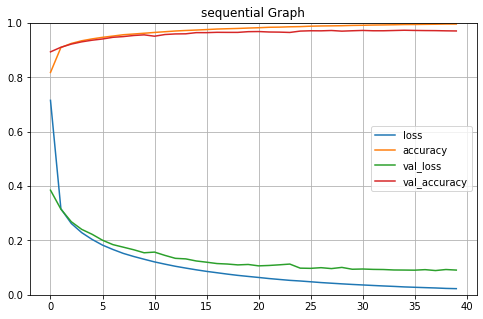

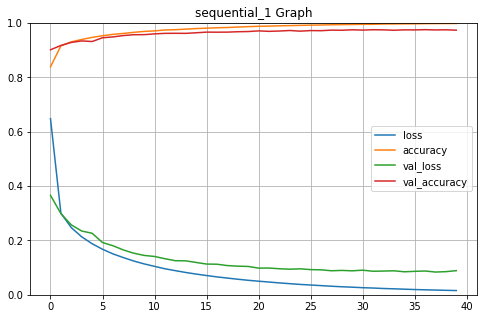

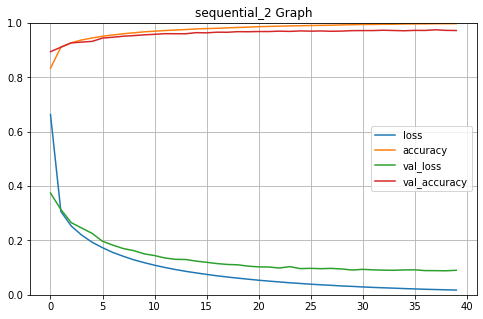

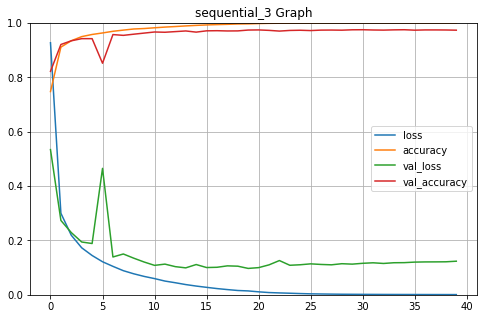

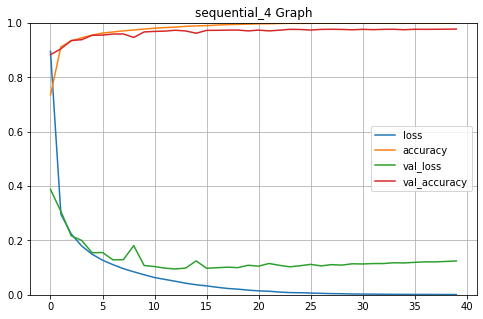

In [9]:
for m in models:
    pd.DataFrame(m.history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,1)
    plt.title(f'{m._name} Graph')
plt.savefig('sequential_graphs.png')

In [10]:
losses = []
tst_losses = []
accuracys = []
tst_accuracys = []
for m in models:
    (loss,acc) = m.evaluate(X_train,y_train)
    (tst_loss,tst_acc) = m.evaluate(X_val, y_val)
    losses.append(loss)
    tst_losses.append(tst_loss)
    accuracys.append(acc)
    tst_accuracys.append(tst_acc)


132/132 [==============================] - 0s 849us/step - loss: 0.1244 - accuracy: 0.9776


In [11]:
d = {'model_name': ['1','2','3','4','5'], 
    'nodes_in_layers': [[300,100],[1000,100],[500,100],[300,100,300,100,100],[200,200,200,100,100]],
    'num_layers':[2,2,2,5,5],
    'process_time': times,
    'trng_accr': accuracys,
    'tst_accr': tst_accuracys}
results_df = pd.DataFrame(d)

In [12]:
tst_predictions = []
for m in models:
    test_prediction = m.predict(X_test)
    test_predictions_classes = np.argmax(m.predict(X_test), axis=-1)
    tst_predictions.append(test_predictions_classes)

## Output results

In [13]:
for i in range(len(models)):
    results = pd.DataFrame(tst_predictions[i])
    results.index = np.arange(1, len(results) + 1)
    results.to_csv(f'{i}_model_results.csv')

Lets try a different activation function (selu) and optimizer (adam).

In [14]:
# selu model
model5 = keras.models.Sequential([
    Flatten(input_shape=[784]),
    Dense(200,activation='selu',kernel_initializer='lecun_normal'),
    Dense(200,activation='selu',kernel_initializer='lecun_normal'),
    Dense(200,activation='selu',kernel_initializer='lecun_normal'),
    Dense(200,activation='selu',kernel_initializer='lecun_normal'),
    Dense(200,activation='selu',kernel_initializer='lecun_normal'),
    Dense(10,activation='softmax')
])
model5.compile(loss='sparse_categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy'])
model5.fit(X_train,y_train, epochs=50,
    validation_data=(X_val,y_val))


Epoch 1/50
1182/1182 [==============================] - 3s 3ms/step - loss: 0.3515 - accuracy: 0.8947 - val_loss: 0.2466 - val_accuracy: 0.9295
Epoch 2/50
1182/1182 [==============================] - 3s 3ms/step - loss: 0.2038 - accuracy: 0.9393 - val_loss: 0.1849 - val_accuracy: 0.9452
Epoch 3/50
1182/1182 [==============================] - 3s 3ms/step - loss: 0.1644 - accuracy: 0.9500 - val_loss: 0.1964 - val_accuracy: 0.9443
Epoch 4/50
1182/1182 [==============================] - 3s 2ms/step - loss: 0.1277 - accuracy: 0.9606 - val_loss: 0.1917 - val_accuracy: 0.9471
Epoch 5/50
1182/1182 [==============================] - 3s 3ms/step - loss: 0.1179 - accuracy: 0.9643 - val_loss: 0.1329 - val_accuracy: 0.9660
Epoch 6/50
1182/1182 [==============================] - 3s 2ms/step - loss: 0.1003 - accuracy: 0.9698 - val_loss: 0.1636 - val_accuracy: 0.9595
Epoch 7/50
1182/1182 [==============================] - 3s 2ms/step - loss: 0.0941 - accuracy: 0.9720 - val_loss: 0.1491 - val_accuracy:

In [15]:
(loss,acc) = model5.evaluate(X_train,y_train)
(tst_loss,tst_acc) = m.evaluate(X_val, y_val)
losses.append(loss)
tst_losses.append(tst_loss)
accuracys.append(acc)
tst_accuracys.append(tst_acc)

132/132 [==============================] - 0s 803us/step - loss: 0.1244 - accuracy: 0.9776


In [16]:
results_df = results_df.append({'model_name': 6, 
    'nodes_in_layers':[200,200,200,200,200],
    'num_layers': 5,
    'process_time': times[4],
    'trng_accr': acc,
    'tst_accr': tst_acc}, ignore_index=True)

In [17]:
model5_predictions = np.argmax(model5.predict(X_test), axis=-1)
results = pd.DataFrame(model5_predictions)
results.index = np.arange(1, len(results) + 1)
results.to_csv(f'model5_results.csv')

# keras Tuner - hyperparameter searching

In [18]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(Flatten(input_shape=[784]))

    hp_units = hp.Int('units', min_value = 32, max_value = 1000, step = 4)
    model.add(Dense(units = hp_units, activation = 'selu', kernel_initializer='lecun_normal'))
    model.add(Dense(10))

    hp_learning_rate = hp.Choice('learning_rate', values = [10.0,1.0,1e-1,1e-2,1e-3,1e-4])

    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
        metrics = ['accuracy'])
    
    return model

In [19]:
tuner = kt.Hyperband(model_builder,
    objective = 'val_accuracy',
    max_epochs = 50,
    factor=3,
    directory = 'my_dir',
    project_name = 'selu_smaller_step')

INFO:tensorflow:Reloading Oracle from existing project my_dir\selu_smaller_step\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\selu_smaller_step\tuner0.json


In [20]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

In [21]:
tuner.search(X_train,y_train, epochs=10, 
    validation_data = (X_val, y_val),
    callbacks = [ClearTrainingOutput()])

INFO:tensorflow:Oracle triggered exit


In [22]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")


The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 500 and the optimal learning rate for the optimizer
is 0.001.



In [23]:
time_start = datetime.datetime.now()
model = tuner.hypermodel.build(best_hps)
time_end = datetime.datetime.now()
model.fit(X_train, y_train, epochs = 10,
    validation_data = (X_val, y_val))

Epoch 1/10
1182/1182 [==============================] - 3s 2ms/step - loss: 0.3514 - accuracy: 0.8970 - val_loss: 0.2784 - val_accuracy: 0.9212
Epoch 2/10
1182/1182 [==============================] - 3s 2ms/step - loss: 0.2103 - accuracy: 0.9388 - val_loss: 0.2272 - val_accuracy: 0.9326
Epoch 3/10
1182/1182 [==============================] - 3s 2ms/step - loss: 0.1420 - accuracy: 0.9569 - val_loss: 0.1441 - val_accuracy: 0.9531
Epoch 4/10
1182/1182 [==============================] - 3s 2ms/step - loss: 0.1032 - accuracy: 0.9681 - val_loss: 0.1189 - val_accuracy: 0.9626
Epoch 5/10
1182/1182 [==============================] - 2s 2ms/step - loss: 0.0814 - accuracy: 0.9748 - val_loss: 0.1048 - val_accuracy: 0.9686
Epoch 6/10
1182/1182 [==============================] - 3s 2ms/step - loss: 0.0614 - accuracy: 0.9808 - val_loss: 0.1078 - val_accuracy: 0.9674
Epoch 7/10
1182/1182 [==============================] - 3s 2ms/step - loss: 0.0495 - accuracy: 0.9843 - val_loss: 0.1171 - val_accuracy:

In [24]:
(loss, acc) = model.evaluate(X_train,y_train)
(tst_loss, tst_acc)= model.evaluate(X_val, y_val)
results_df = results_df.append({'model_name': 7, 
    'nodes_in_layers':[500],
    'num_layers': 1,
    'process_time': time_end-time_start,
    'trng_accr': acc,
    'tst_accr': tst_acc}, ignore_index=True)

132/132 [==============================] - 0s 743us/step - loss: 0.1166 - accuracy: 0.9702


In [25]:
predictions = np.argmax(model.predict(X_test), axis=-1)
results = pd.DataFrame(predictions)
results.index = np.arange(1, len(results) + 1)
results.to_csv(f'keras_tuned_selu2_results.csv')

# Summary
## Kaggle Team Name: Digit Finders


## Data Pre-processing:

We have 42000 images available as training data. 

We have split this data and used 10% as validation data.

Then we have scaled the data and divide the input features by 255.

## Creating model:

We have created 5 models using Sequential API to build the first layer and the Dense output layer with 10 neurons (one for each class) using "softmax" activation function.

1) Model: (2 Layer)
First Dense hidden layer with 300 neurons & using ReLU activation function.
Second Dense hidden layer with 100 neurons & using ReLU activation function. 
   
2) Model1: (2 Layer)
First Dense hidden layer with 1000 neurons & using ReLU activation function. 
Second Dense hidden layer with 100 neurons & using ReLU activation function.
   
3) Model2: (2 Layer)
First Dense hidden layer with 500 neurons & using ReLU activation function. 
Second Dense hidden layer with 100 neurons & using ReLU activation function.
   
4) Model3: (5 Layer)
 First Dense hidden layer with 300 neurons & using ReLU activation function.
 Second Dense hidden layer with 100 neurons & using ReLU activation function.
 Third Dense hidden layer with 300 neurons & using ReLU activation function.
 Fourth Dense hidden layer with 100 neurons & using ReLU activation function.
 Fifth Dense hidden layer with 100 neurons & using ReLU activation function.
   
5) Model4: (5 Layer) 
  First Dense hidden layer with 200 neurons & using ReLU activation function. 
  Second Dense hidden layer with 200 neurons & using ReLU activation function.
  Third Dense hidden layer with 200 neurons & using ReLU activation function.
  Fourth Dense hidden layer with 100 neurons & using ReLU activation function.
  Fifth Dense hidden layer with 100 neurons & using ReLU activation function.

6) Model5: (5 Layer Adam Build)
  First Dense hidden layer with 200 neurons & using SeLU activation function.
  Second Dense hidden layer with 200 neurons & using SeLU activation function.
  Third Dense hidden layer with 200 neurons & using SeLU activation function.
  Fourth Dense hidden layer with 100 neurons & using SeLU activation function.
  Fifth Dense hidden layer with 100 neurons & using SeLU activation function.
7) Model6: Hypertuned Adam Build
  First Dense hidden layer with 352 nuerons & using ReLU activation function.
8) Model7: Hypertuned Adam Build
  First Dense hidden layer with 500 nuerons & using SeLU activation function.

## Loss Function:

We have chosen the loss function to be "Sparse Categorical Crossentropy" as we have sparse labels and the classes are exclusive & "sgd", which is the Stochastic Gradient Descent as the optimizer for our model and with a default learning rate of 0.01.

## Best model:

Then we have used the "Checkpoint" and saved the best model from amongst the 5 models described above.

## Results:
Our results were very favorable for relu and seul in the 97th percentile for test accuracy. You can see a representative summary in our results_df dataframe, shown in the next codeblock. We experimented with the keras tuner and hyperparameter optimization. We were able to increase our score slightly on kaggle by .05 with testing learning_rate, optimizer selection, and node size. It's our recommendation to management that we spend more time with hyperparameter optimization to allow better tuning of the model's hyperparameters for the last 3 percent. We know we can get there.

## Model Accuracy Results

In [26]:
results_df

,model_name,nodes_in_layers,num_layers,process_time,trng_accr,tst_accr
0,1,"[300, 100]",2,00:01:09.888667,0.997064,0.970714
1,2,"[1000, 100]",2,00:03:11.191971,0.998413,0.973571
2,3,"[500, 100]",2,00:02:02.507259,0.998228,0.972381
3,4,"[300, 100, 300, 100, 100]",5,00:01:38.456294,1.000000,0.973571
4,5,"[200, 200, 200, 100, 100]",5,00:01:25.020569,1.000000,0.977619
5,6,"[200, 200, 200, 200, 200]",5,00:01:25.020569,0.995185,0.977619
6,7,[500],1,00:00:00.247055,0.990688,0.970238
